# Representation Learning

## Packages and Presets

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor

import yaml
import math
from tqdm import tqdm, trange
import os

import matplotlib.pyplot as plt
import seaborn as sns   

import copy
from tqdm import tqdm

from sklearn.metrics import (
    f1_score, 
    balanced_accuracy_score, 
    confusion_matrix,
    ConfusionMatrixDisplay, 
    accuracy_score,
    classification_report
)
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from torch.utils.tensorboard import SummaryWriter
from imblearn.over_sampling import SMOTE

import warnings

from info_nce import InfoNCE

from lightgbm import LGBMClassifier


from representation_learning_utils import (
    MITBIH_Dataset,
    MITBIH_Augment_Dataset,
    PTB_Dataset,
    EarlyStopping,
    set_all_seeds,
    train_and_validate,
    test,
)


pd.set_option('display.max_columns', None)

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with open("representation_learning_config.yaml", "r") as file:
    config = yaml.safe_load(file)

## Data Loading and Preprocessing

In [3]:
# Load data
train_df = pd.read_csv(config["paths"]["mitbih_train"], header=None)
test_df = pd.read_csv(config["paths"]["mitbih_train"], header=None)

In [4]:
print(f"{train_df.shape=}")
print(f"{test_df.shape=}")

train_df.shape=(87554, 188)
test_df.shape=(87554, 188)


In [5]:
# relative frequency of each label class in %
train_df.iloc[:, -1].value_counts(normalize = True) * 100

187
0.0    82.772917
4.0     7.345181
2.0     6.610777
1.0     2.539005
3.0     0.732120
Name: proportion, dtype: float64

As we can see the train set is very imbalanced. As a consequence, we will once again make use of SMOTE oversampling.

In [6]:
X_train_full = train_df.iloc[:, :-1].to_numpy()
y_train_full = train_df.iloc[:, -1].to_numpy()

X_test = test_df.iloc[:, :-1].to_numpy()
y_test = test_df.iloc[:, -1].to_numpy()

Split into train and validation sets:

In [7]:
# X_train, X_val, y_train, y_val = train_test_split(
#     X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=config["general"]["seed"]
# )
X_train = X_train_full
y_train = y_train_full

As mentioned above, we will oversample the minority classes using SMOTE.

In [8]:
sm = SMOTE(random_state=config["general"]["seed"])
X_train, y_train = sm.fit_resample(X_train, y_train)
print(f"{X_train.shape=}")
print(f"{np.unique(y_train, return_counts=True)=}")

X_train.shape=(362355, 187)
np.unique(y_train, return_counts=True)=(array([0., 1., 2., 3., 4.]), array([72471, 72471, 72471, 72471, 72471]))


In [9]:
train_loader = DataLoader(
        MITBIH_Dataset(X_train, y_train),
        batch_size=config["dataloader"]["train_batch_size"],
        shuffle=True,
        pin_memory=True,
        num_workers=0,
    )
# val_loader = DataLoader(
#     MITBIH_Dataset(X_val, y_val),
#     batch_size=256,
#     shuffle=False,
#     pin_memory=True,
#     num_workers=0,
# )

test_loader = DataLoader(
    MITBIH_Dataset(X_test, y_test),
    batch_size=config["dataloader"]["test_batch_size"],
    shuffle=False,
    pin_memory=True,
    num_workers=0,
)

In [10]:
train_loader_augmented = DataLoader(
    MITBIH_Augment_Dataset(X_train),
    batch_size=config["dataloader"]["augmented_train_batch_size"],
    shuffle=True,
    pin_memory=True,
    num_workers=28,
)

Note that in the following CNN we do not normalize the resulting embeddings, since this will be done in a later step and is already implemented in the `InfoNCE` loss by default.

In [11]:
# We based our CNN on this: https://medium.com/@chen-yu/building-a-customized-residual-cnn-with-pytorch-471810e894ed
class CNNEncoder(nn.Module):
    def __init__(self, latent_dim: int, in_channels: int):
        super().__init__()

        # self.conv1 = self._create_conv_block(in_channels, 32, 3, 1)
        # self.conv2 = self._create_conv_block(32, 64, 3, 1)
        # self.conv3 = self._create_conv_block(64, 128, 3, 1)
        self.conv1 = self._create_conv_block(in_channels, 512, 3, 1)
        self.conv2 = self._create_conv_block(512, 512, 3, 1)
        self.conv3 = self._create_conv_block(512, 512, 3, 1)
        self.conv4 = self._create_conv_block(512, 512, 3, 1)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(output_size = 10)
        
        
        # Flattening and final linear layer
        self.flatten = nn.Flatten(1)
        self.fc = nn.Sequential(
            nn.Linear(5120, 256),
            nn.Hardswish(),
            nn.Dropout(p=0.2),  
            nn.Linear(256, latent_dim)
        )

    def forward(self, x: Tensor) -> Tensor:
        x = x.unsqueeze(1) # Add channel dimension
        # now: [batch_size, in_channels, seq_len] i.e. [batch_size, 1, 187]
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.adaptive_pool(x)
        
        x = self.flatten(x)
        x = self.fc(x)
        return x
    
    def _create_conv_block(self, in_channels: int, out_channels: int, kernel_size: int, stride: int):
        return nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels, 
                out_channels=out_channels, 
                kernel_size=kernel_size, 
                stride=stride, 
                padding=1, 
                bias=False
            ),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )


set_all_seeds(config["general"]["seed"])
encoder=CNNEncoder(latent_dim=config["encoder"]["latent_dim"], in_channels=1).to(DEVICE)

In [12]:
class ContrastiveNet(nn.Module):
    def __init__(self, encoder: nn.Module, latent_dim: int, project_size: int):
        super().__init__()
        self.encoder = encoder
        self.projection_head = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(latent_dim, project_size)
        )
    def forward(self, x: Tensor) -> Tensor:
        x = self.encoder(x)
        x = self.projection_head(x)
        return x
        

We use a model that resembles the CDCK* speaker models used in the paper `Representation Learning with Contrastive Predictive Coding`. The class below was inspired by this
[GitHub repository](https://github.com/jefflai108/Contrastive-Predictive-Coding-PyTorch/blob/master/src/model/model.py).

In [13]:
def train_encoder_one_epoch(
    model: nn.Module,
    optimizer: optim.Optimizer,
    criterion: nn.Module,
    train_loader: DataLoader,
    device: torch.device,
) -> tuple[float, float, float, float]:
    """Train the model for one epoch

    Args:
        model (nn.Module): Model to train
        optimizer (optim.Optimizer): Optimizer to use
        criterion (nn.Module): Loss function
        train_loader (DataLoader): Train data loader
        device (torch.device): Device on which calculations are executed

    Returns:
        tuple[float, float, float, float]: Tuple of train loss, accuracy,
            balanced accuracy and f1 score
    """

    model.train()

    total_loss = 0.0
    for seq, seq_aug, seq_neg in tqdm(train_loader):
        seq, seq_aug, seq_neg = seq.to(device), seq_aug.to(device), seq_neg.to(device)
        optimizer.zero_grad()

        output = model(seq)
        output_aug = model(seq_aug)
        output_neg = model(seq_neg)
        loss = criterion(output, output_aug, output_neg)
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    # calculate metrics
    train_loss = total_loss / len(train_loader.dataset)
    return train_loss

In [14]:
optimizer = optim.AdamW(
        encoder.parameters(),
        lr=config["adamw"]["learning_rate"],
        weight_decay=config["adamw"]["weight_decay"],
)
criterion = InfoNCE()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=config["scheduler"]["factor"],
    patience=config["scheduler"]["patience"],
)

early_stopping = EarlyStopping(
    start=config["early_stopping"]["start"],
    patience=config["early_stopping"]["patience"],
    verbose=True,
    mode="max",
)
summary_writer = SummaryWriter(log_dir=config["paths"]["summary_writer"])

In [15]:
contrastive_model = ContrastiveNet(encoder, config["encoder"]["latent_dim"], config["contrastive_model"]["projection_head"]).to(DEVICE)

In [16]:
for i in range(15):
    loss = train_encoder_one_epoch(
        model=contrastive_model,
        optimizer=optimizer,
        criterion=criterion,
        train_loader=train_loader_augmented,
        device=DEVICE
    )
    print(f"{i=}: {loss=}")

100%|██████████| 2831/2831 [01:18<00:00, 35.87it/s]


i=0: loss=0.006634669147889447


100%|██████████| 2831/2831 [01:18<00:00, 35.92it/s]


i=1: loss=0.004858053112511663


100%|██████████| 2831/2831 [01:18<00:00, 35.95it/s]


i=2: loss=0.004254653770483005


100%|██████████| 2831/2831 [01:18<00:00, 35.89it/s]


i=3: loss=0.003883108697511179


100%|██████████| 2831/2831 [01:18<00:00, 35.92it/s]


i=4: loss=0.003685215609106636


100%|██████████| 2831/2831 [01:19<00:00, 35.82it/s]


i=5: loss=0.0034559909063347116


100%|██████████| 2831/2831 [01:19<00:00, 35.82it/s]


i=6: loss=0.003359315826193727


100%|██████████| 2831/2831 [01:19<00:00, 35.83it/s]


i=7: loss=0.003301595864231676


100%|██████████| 2831/2831 [01:18<00:00, 35.92it/s]


i=8: loss=0.003170582953205605


100%|██████████| 2831/2831 [01:18<00:00, 35.92it/s]


i=9: loss=0.0031398934269203996


100%|██████████| 2831/2831 [01:19<00:00, 35.83it/s]


i=10: loss=0.0030497597773547426


100%|██████████| 2831/2831 [01:18<00:00, 35.92it/s]


i=11: loss=0.003083271162829338


100%|██████████| 2831/2831 [01:18<00:00, 35.90it/s]


i=12: loss=0.00287952452323947


100%|██████████| 2831/2831 [01:19<00:00, 35.82it/s]


i=13: loss=0.0028678817808553236


100%|██████████| 2831/2831 [01:18<00:00, 35.89it/s]

i=14: loss=0.0027671493794671122


In [17]:
mitbih_train_embeddings = []
mitbih_y_train = []

contrastive_model.eval()


for seq, y in tqdm(train_loader):
    seq = seq.to(DEVICE)
    with torch.no_grad():
        output = contrastive_model.encoder(seq).cpu().numpy()
        mitbih_train_embeddings.append(output)
        mitbih_y_train.append(y)

mitbih_train_embeddings = np.vstack(mitbih_train_embeddings)
mitbih_y_train = np.concatenate(mitbih_y_train)

100%|██████████| 5662/5662 [00:09<00:00, 620.12it/s]


In [18]:
mitbih_test_embeddings = []
mitbih_y_test = []


contrastive_model.eval()

for seq, y in tqdm(test_loader):
    seq =seq.to(DEVICE)
    with torch.no_grad():
        output = contrastive_model.encoder(seq).cpu().numpy()
        mitbih_test_embeddings.append(output)
        mitbih_y_test.append(y)
    
mitbih_test_embeddings = np.vstack(mitbih_test_embeddings)
mitbih_y_test = np.concatenate(mitbih_y_test)

100%|██████████| 343/343 [00:01<00:00, 179.84it/s]


In [19]:
boost = LGBMClassifier(
    n_estimators=500,
    random_state=config["general"]["seed"],
    n_jobs=-1,
)

In [20]:
# save train and test embeddings, y_train, y_test to numpy:
np.save("embeddings/mitbih_train_embeddings.npy", mitbih_train_embeddings)
np.save("embeddings/mitbih_test_embeddings.npy", mitbih_test_embeddings)
np.save("embeddings/mitbih_y_train.npy", y_train)
np.save("embeddings/mitbih_y_test.npy", y_test)

In [21]:
# Load data:
ptb_train_df = pd.read_csv(config["paths"]["ptb_train"], header=None)
ptb_test_df = pd.read_csv(config["paths"]["ptb_test"], header=None)

# separate features and labels:
ptb_X_train = ptb_train_df.iloc[:, :-1].to_numpy()
ptb_y_train = ptb_train_df.iloc[:, -1].to_numpy()

# 0-pad sequences to uniform, 190, length:
ptb_X_test = ptb_test_df.iloc[:, :-1].to_numpy()
ptb_y_test = ptb_test_df.iloc[:, -1].to_numpy()

In [22]:
sm = SMOTE(random_state=config["general"]["seed"])
ptb_X_train, ptb_y_train = sm.fit_resample(ptb_X_train, ptb_y_train)
print(ptb_X_train.shape, ptb_y_train.shape)
print(np.unique(ptb_y_train, return_counts=True))

(16808, 187) (16808,)
(array([0., 1.]), array([8404, 8404]))


In [23]:
ptb_train_loader = DataLoader(
    PTB_Dataset(ptb_X_train, ptb_y_train),
    batch_size=32,
    shuffle=True,
    pin_memory=True,
    num_workers=0,
)
ptb_test_loader = DataLoader(
    PTB_Dataset(ptb_X_test, ptb_y_test),
    batch_size=256,
    shuffle=False,
    pin_memory=True,
    num_workers=0,
)

In [24]:
ptb_train_embeddings = []
ptb_y_train = []


contrastive_model.eval()

for seq, y in tqdm(ptb_train_loader):
    seq = seq.to(DEVICE)
    with torch.no_grad():
        output = contrastive_model.encoder(seq).cpu().numpy()
        ptb_train_embeddings.append(output)
        ptb_y_train.append(y)

ptb_train_embeddings = np.vstack(ptb_train_embeddings)
ptb_y_train = np.concatenate(ptb_y_train)

100%|██████████| 526/526 [00:00<00:00, 1012.03it/s]


In [25]:
ptb_test_embeddings = []
ptb_y_test = []


contrastive_model.eval()

for seq, y in tqdm(ptb_test_loader):
    seq = seq.to(DEVICE)
    with torch.no_grad():
        output = contrastive_model.encoder(seq).cpu().numpy()
        ptb_test_embeddings.append(output)
        ptb_y_test.append(y)

ptb_test_embeddings = np.vstack(ptb_test_embeddings)
ptb_y_test = np.concatenate(ptb_y_test)

100%|██████████| 12/12 [00:00<00:00, 187.34it/s]


In [26]:
np.save("embeddings/ptb_train_embeddings.npy", ptb_train_embeddings)
np.save("embeddings/ptb_test_embeddings.npy", ptb_test_embeddings)
np.save("embeddings/ptb_y_train.npy", ptb_y_train)
np.save("embeddings/ptb_y_test.npy", ptb_y_test)

In [27]:
boost.fit(mitbih_train_embeddings, mitbih_y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32640
[LightGBM] [Info] Number of data points in the train set: 362355, number of used features: 128
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438


LGBMClassifier(n_estimators=500, n_jobs=-1, random_state=42)

In [28]:
y_preds = boost.predict(mitbih_test_embeddings)

In [29]:
accuracy = accuracy_score(mitbih_y_test, y_preds)
balanced_accuracy = balanced_accuracy_score(mitbih_y_test, y_preds)
print(f"{accuracy=}")
print(f"{balanced_accuracy=}")

accuracy=0.9999657354318477
balanced_accuracy=0.9999917208262616


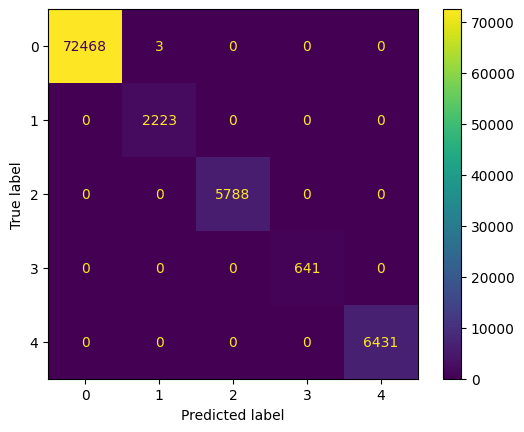

In [30]:
cm = confusion_matrix(mitbih_y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
disp.plot()

In [31]:
print(f"Test accuracy: {accuracy_score(y_test, y_preds):.6f}")
print(f"Test balanced accuracy: {balanced_accuracy_score(y_test, y_preds):.6f}")
print(f"Test f1 score: {f1_score(y_test, y_preds, average = 'weighted'):.6f}")

Test accuracy: 0.999966
Test balanced accuracy: 0.999992
Test f1 score: 0.999966


In [32]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     72471
         1.0       1.00      1.00      1.00      2223
         2.0       1.00      1.00      1.00      5788
         3.0       1.00      1.00      1.00       641
         4.0       1.00      1.00      1.00      6431

    accuracy                           1.00     87554
   macro avg       1.00      1.00      1.00     87554
weighted avg       1.00      1.00      1.00     87554



In [33]:
#!!! our implementation is based on this GitHub repository: 
#!!! https://github.com/jefflai108/Contrastive-Predictive-Coding-PyTorch/blob/master/src/model/model.py

class CPC(nn.Module):
    def __init__(self, encoder, config):
        super().__init__()
        self.encoder = encoder
        self.predictor = nn.Sequential(
            nn.Linear(config["latent_dim"], config["latent_dim"]),
            nn.ReLU(),
            nn.Linear(config["latent_dim"], config["latent_dim"])
        )
        self.info_nce = InfoNCE()

    def forward(self, x, x_aug):
        z = self.encoder(x)
        z_aug = self.encoder(x_aug)
        z_pred = self.predictor(z)
        return self.info_nce(z_pred, z_aug)

In [34]:
def train_cpc(model, train_loader, val_loader, config):
    model = model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    early_stopping = EarlyStopping(patience=config["patience"], verbose=True)
    writer = SummaryWriter()

    for epoch in trange(config["epochs"], desc="Epoch"):
        model.train()
        train_loss = 0
        for x, x_aug in train_loader:
            x, x_aug = x.to(DEVICE), x_aug.to(DEVICE)
            optimizer.zero_grad()
            loss = model(x, x_aug)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        writer.add_scalar("Loss/train", train_loss, epoch)

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for x, x_aug in val_loader:
                x, x_aug = x.to(DEVICE), x_aug.to(DEVICE)
                loss = model(x, x_aug)
                val_loss += loss.item()
            val_loss /= len(val_loader)
            writer.add_scalar("Loss/val", val_loss, epoch)
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

    return model